In [1]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



In [2]:
df = pd.read_csv('PPG_Dataset.csv')
print(df.head())
print(df.info())
X = df.iloc[:, :-1]  
y = df.iloc[:, -1]   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

          0         1         2         3         4         5         6  \
0 -0.015552  0.016963  0.013575  0.027204  0.068154  0.129259  0.127915   
1  0.002323  0.002754  0.022539  0.228807  0.107751  0.034439  0.086007   
2  0.050481 -0.339781  0.265111  0.045092  0.040086  0.087173  0.092814   
3  0.023882  0.016561  0.248547  0.054567  0.128032  0.085954  0.107359   
4 -0.058591  0.171551  0.057262  0.270869  0.138357  0.078509  0.062504   

          7         8         9  ...      1991      1992      1993      1994  \
0  0.345174  0.197811  0.167651  ... -0.426464 -0.346976 -0.132168 -0.252098   
1  0.155667  0.163327  0.223759  ... -0.169345 -0.356808 -0.338996 -0.292489   
2  0.099586 -0.143305  0.164186  ... -0.401426 -0.402333 -0.373426 -0.303710   
3  0.207137  0.174547 -0.100118  ... -0.390700 -0.353882 -0.294014 -0.267005   
4  0.104447  0.134795  0.194248  ... -0.391598 -0.334490 -0.326873 -0.249881   

       1995      1996      1997      1998      1999  Label  
0 -0.24

## ML-решение 

In [3]:
def train_random_forest(X_train, X_test, y_train, y_test):
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Random Forest Accuracy:", accuracy)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    return rf_model


## Фильтрация сигнала

In [4]:
# Рекуррентный 
def recursive_filter(data, coef=0.1):
    result = np.copy(data)
    beta = 1.0 - coef
    for idx in range(1, data.size):
        result[idx] = coef * data[idx] + beta * result[idx-1]
    return result

# Сверточный
def convolutional_filter(input_signal, n=5):
    mask = np.full(n, 1/n)
    smoothed = signal.convolve(input_signal, mask, mode='same')
    return smoothed

# Фурье
def fourier_filter(signal_data, threshold=0.1):
    fft_vals = fft(signal_data)
    freqs = fftfreq(len(signal_data))
    fft_vals[np.abs(freqs) > threshold] = 0
    return np.real(np.fft.ifft(fft_vals))


In [5]:
def extract_features(signal):
    stats = {}
    stats['mean'] = float(np.mean(signal))
    stats['std'] = float(np.std(signal))
    stats['max'] = float(signal.max())
    stats['min'] = float(signal.min())
    stats['range'] = stats['max'] - stats['min']
    stats['median'] = float(np.median(signal))
    return stats

def process_signals(data, method='recursive'):
    results = []
    
    filters = {
        'recursive': recursive_filter,
        'convolutional': convolutional_filter,
        'fourier': fourier_filter
    }
    
    if method not in filters:
        raise ValueError(f"Unsupported method: {method}")
    
    for idx in range(len(data)):
        raw_signal = data.iloc[idx].values
        filtered = filters[method](raw_signal)
        stats = extract_features(filtered)
        results.append(stats)
    
    return pd.DataFrame(results)

def plot_filtered_signals(raw_data):
    fig, axes = plt.subplots(4, 1, figsize=(12, 8))
    fig.suptitle('Сравнение методов фильтрации')
    
    axes[0].plot(raw_data, 'b-', label='Исходный')
    axes[0].set_title('Исходный сигнал')
    
    signals = {
        'Рекурсивный': recursive_filter(raw_data),
        'Сверточный': convolutional_filter(raw_data),
        'Фурье': fourier_filter(raw_data)
    }
    
    for idx, (name, filtered) in enumerate(signals.items(), 1):
        axes[idx].plot(filtered, 'r-', label=name)
        axes[idx].set_title(f'{name} фильтр')
        axes[idx].grid(True)
    
    plt.tight_layout()
    plt.show()

Визуализация обработки сигнала различными фильтрами:


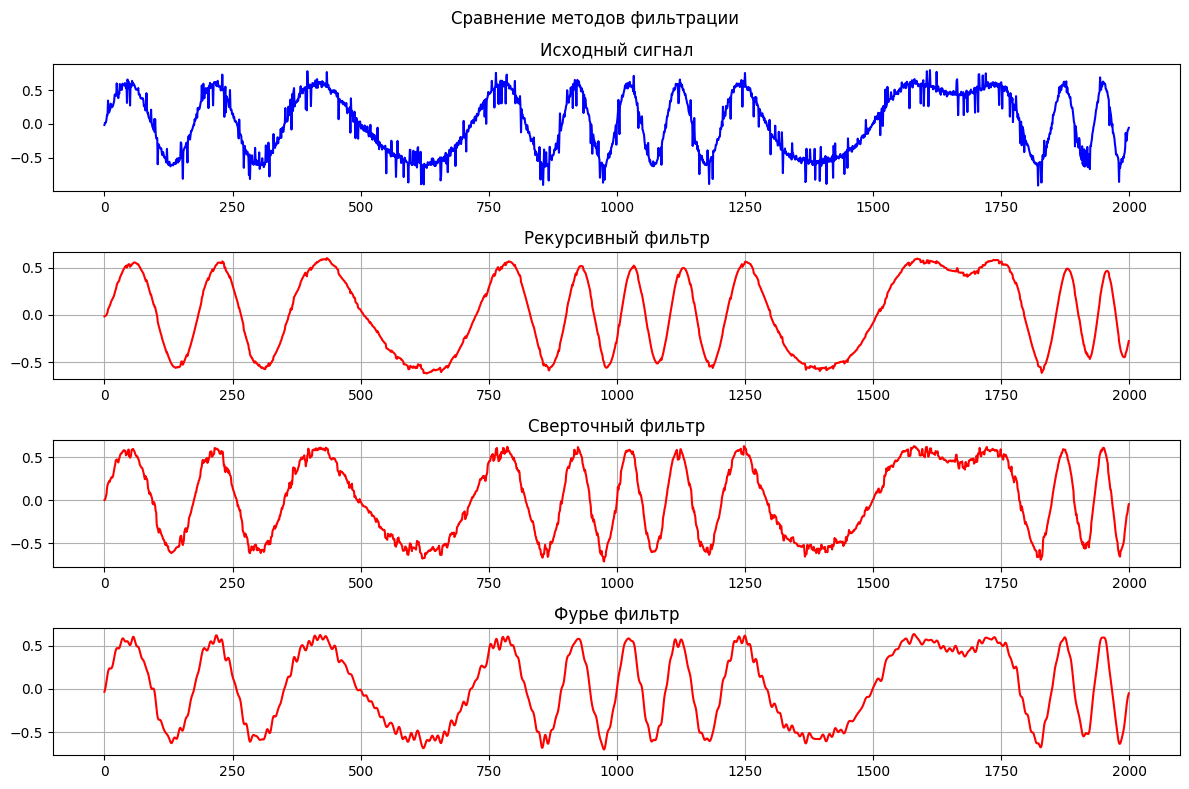


Базовый анализ:
Random Forest Accuracy: 0.9631782945736435

Classification Report:
              precision    recall  f1-score   support

          MI       0.97      0.96      0.96       256
      Normal       0.96      0.97      0.96       260

    accuracy                           0.96       516
   macro avg       0.96      0.96      0.96       516
weighted avg       0.96      0.96      0.96       516


Анализ с применением фильтров:

Рекурсивный фильтр:
Точность: 0.9632

Подробный отчет:
              precision    recall  f1-score   support

          MI       0.97      0.96      0.96       256
      Normal       0.96      0.97      0.96       260

    accuracy                           0.96       516
   macro avg       0.96      0.96      0.96       516
weighted avg       0.96      0.96      0.96       516


Сверточный фильтр:
Точность: 0.9593

Подробный отчет:
              precision    recall  f1-score   support

          MI       0.96      0.96      0.96       256
      Norm

In [6]:
sample = X.iloc[0].values
print("Визуализация обработки сигнала различными фильтрами:")
plot_filtered_signals(sample)

print("\nБазовый анализ:")
base_model = train_random_forest(X_train, X_test, y_train, y_test)

print("\nАнализ с применением фильтров:")
methods = {
    'recursive': 'Рекурсивный',
    'convolutional': 'Сверточный',
    'fourier': 'Фурье'
}

results = {}
for method_key, method_name in methods.items():
    print(f"\n{method_name} фильтр:")
    
    train_filtered = process_signals(X_train, method_key)
    test_filtered = process_signals(X_test, method_key)
    
    model = RandomForestClassifier(
        n_estimators=100, 
        random_state=42
    )
    
    model.fit(train_filtered, y_train)
    
    predictions = model.predict(test_filtered)
    acc = accuracy_score(y_test, predictions)
    results[method_name] = acc
    
    print(f"Точность: {acc:.4f}")
    print("\nПодробный отчет:")
    print(classification_report(y_test, predictions))

print("\nИтоговое сравнение:")
for method, acc in results.items():
    print(f"{method:12} : {acc:.4f}")